In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [2]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

# def data_scaled(N, m, scale, seed):
#     np.random.seed(seed)
#     R = np.vstack([np.random.normal(
#     i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
#     return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

m = 15
data = data_modes(600,m,[1,2,3,4,5],seed = 15)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = 8 + scene*0.5

In [3]:
def loss(y,tau,x,p,alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return y + torch.tensor(l)*(sums - torch.tensor(target)), torch.mean(-data@x)+p*torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0))), totsum/Nsample, sums.detach().numpy()


In [4]:
data = data_modes(600,m,[1,2,3,4,5],seed = 8)
u = lropt.UncertainParameter(m,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(m)
tau = cp.Variable()
y = cp.Variable()
p = cp.Parameter()
p.value = scenarios[0][0]
objective = cp.Minimize(y)
constraints = [p >= 0]
constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
constraints += [cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)

target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init = np.eye(m)
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.0001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.0001,batch_percentage = 0.8)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

In [5]:
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.1, 5, 100), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.1,5, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [6]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_ylabel("Objective value")
    # ax.set_yticks(ticks = [-2e1,0,2e1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    # ax1.set_yticks(ticks = [-2e1,0,2e1])
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if zoom:
        axins = zoomed_inset_axes(ax2, 6, loc="upper center")
        axins.set_xlim(-0.005, 0.1)
        axins.set_ylim(-0.001,0.035)
        axins.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue")
        axins.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
        axins.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        axins.set_xticks(ticks=[])
        axins.set_yticks(ticks=[])
        mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

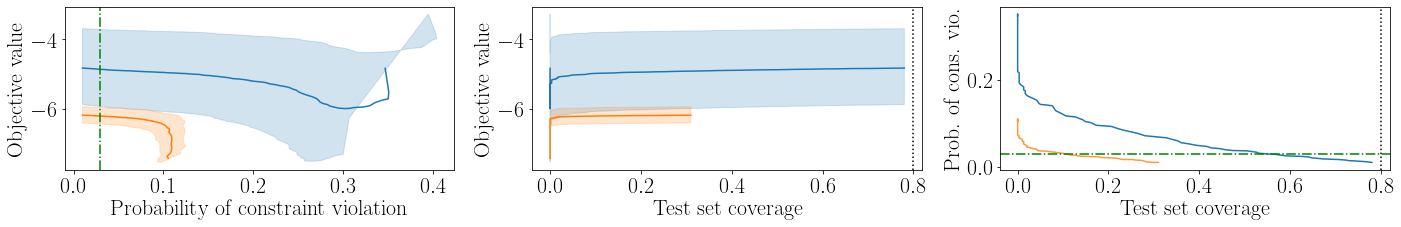

In [8]:
plot_coverage_all(dfgrid,dfgrid2,None, "Portnew10",ind_1=(0,400),ind_2=(0,400), logscale = False, legend = False)

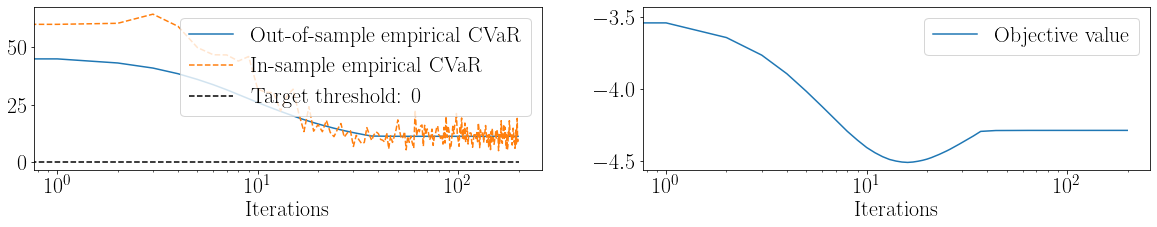

In [249]:
plot_iters(df1,"portnew")

In [250]:
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(2.5, 2.7, 30), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(1.9,2.2,30), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [209]:
reshaped_cvar, x_re = cvar_table(A_fin, b_fin, dfgrid2,test,train,0.012, eps = 0)
standard_cvar, x_st = cvar_table(init, init_bval, dfgrid,test,train,0.03, eps = 0)

In [192]:
make_table(A_fin, b_fin, dfgrid2,test,train,0.0013, eps = 0)

array([[0.09156638, 0.03      , 0.02      , 0.        , 0.        ,
        0.00406504],
       [0.23831206, 0.02333333, 0.02      , 0.        , 0.        ,
        0.00407942],
       [0.38071405, 0.02      , 0.02      , 0.        , 0.        ,
        0.00358238],
       [0.52150545, 0.02      , 0.02      , 0.        , 0.        ,
        0.00315025],
       [0.6615154 , 0.02      , 0.02      , 0.        , 0.        ,
        0.00355133],
       [0.80108613, 0.02      , 0.02      , 0.        , 0.        ,
        0.00339604],
       [0.94038528, 0.02      , 0.02      , 0.        , 0.        ,
        0.00326025],
       [1.07950472, 0.02      , 0.02      , 0.        , 0.        ,
        0.00327121],
       [1.21849906, 0.02      , 0.02      , 0.        , 0.        ,
        0.00307533],
       [1.35740281, 0.02      , 0.02      , 0.        , 0.        ,
        0.00343358]])

In [197]:
make_table(init, init_bval, dfgrid,test,train,0.01, eps = 0)

array([[1.27126254e+00, 2.33333334e-02, 2.99999993e-02, 0.00000000e+00,
        0.00000000e+00, 3.53525000e-03],
       [1.93954594e+00, 2.33333334e-02, 2.99999993e-02, 0.00000000e+00,
        0.00000000e+00, 4.01262500e-03],
       [2.60729767e+00, 2.33333334e-02, 3.33333351e-02, 0.00000000e+00,
        0.00000000e+00, 3.79795800e-03],
       [3.27484308e+00, 2.33333334e-02, 3.33333351e-02, 0.00000000e+00,
        0.00000000e+00, 3.93241700e-03],
       [3.94228242e+00, 2.33333334e-02, 3.33333351e-02, 0.00000000e+00,
        0.00000000e+00, 3.47791600e-03],
       [4.60966000e+00, 2.33333334e-02, 3.66666652e-02, 0.00000000e+00,
        0.00000000e+00, 3.45729100e-03],
       [5.27699849e+00, 2.33333334e-02, 3.66666652e-02, 0.00000000e+00,
        0.00000000e+00, 3.46291700e-03],
       [5.94431066e+00, 2.33333334e-02, 3.66666652e-02, 0.00000000e+00,
        0.00000000e+00, 3.42833400e-03],
       [6.61160427e+00, 2.33333334e-02, 3.66666652e-02, 0.00000000e+00,
        0.00000000e+00, 

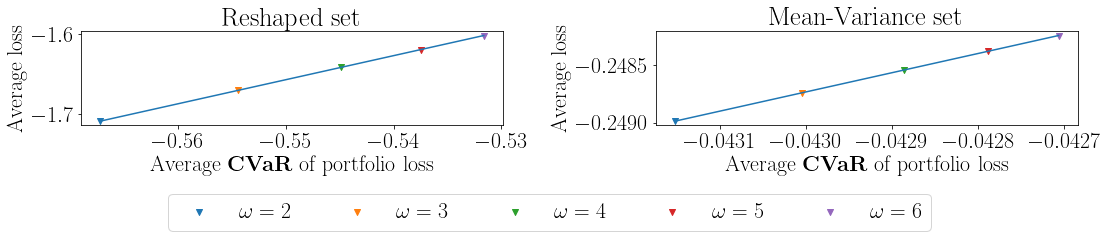

In [211]:
plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(reshaped_cvar[:,1], reshaped_cvar[:,0])
for scene in range(num_scenarios):
    ax1.scatter(reshaped_cvar[scene][1], reshaped_cvar[scene][0], marker = "v", label = r'$\omega = {}$'.format(scene+2))
ax1.set_title("Reshaped set")
ax1.set_ylabel("Average loss")
ax1.set_xlabel(r"Average $\textbf{CVaR}$ of portfolio loss")
fig.legend(bbox_to_anchor=(0.5,-0.06,0,0), loc="center",
                 borderaxespad=0, ncol=5)
ax2.plot(standard_cvar[:,1], standard_cvar[:,0])
for scene in range(num_scenarios):
    ax2.scatter(standard_cvar[scene][1], standard_cvar[scene][0], marker = "v")
ax2.set_ylabel("Average loss")
ax2.set_title("Mean-Variance set")
ax2.set_xlabel(r"Average $\textbf{CVaR}$ of portfolio loss")
plt.tight_layout()
plt.savefig("port_cvar_curves.pdf",bbox_inches='tight')
plt.show()

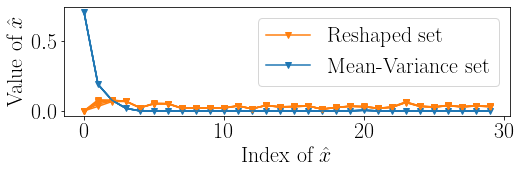

In [212]:
plt.figure(figsize=(8, 2))
plt.plot(x_re[0], color = "tab:orange", label = "Reshaped set", marker = "v")
plt.plot(x_st[0], color = "tab:blue",label = "Mean-Variance set", marker = "v")
for scene in range(1,5):
  plt.plot(x_re[scene], color = "tab:orange", marker = "v")
  plt.plot(x_st[scene], color = "tab:blue")
plt.ylabel("Value of $\hat{x}$")
plt.xlabel("Index of $\hat{x}$")
plt.legend()
plt.savefig("port_xvals.pdf", bbox_inches='tight')
plt.show()

In [6]:

def eval(y,tau,x,p,data,l=10000,quantile = 0.95, target = -0.1):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)
    Nsample = data.shape[0]
    totsum = torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y,(-1-5*p)*data@x - 4*p*tau - y),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))/Nsample
    return totsum


def ret_cvar(y,tau,x,p,data):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)    
    return torch.mean(-data@x), torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0)))

def cvar_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,2))
    xvals = np.zeros((num_scenarios,m))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        ret, cvar = ret_cvar(y.value,tau.value,x.value,p.value,test)
        trial1[scene,0] = ret.item()
        trial1[scene,1] = cvar.item()
        xvals[scene] = x.value
    return trial1, xvals

def make_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )

        trial1[scene,0] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        trial1[scene,1] = eval(y.value,tau.value,x.value,p.value,test).item()
        trial1[scene,2] = eval(y.value,tau.value,x.value,p.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        # trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(m,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        vios[scene] = eval(y.value,tau.value,x.value,p.value,test).item()
        vios_1[scene] = eval(y.value,tau.value,x.value,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time

In [254]:
Ar_saved = np.zeros((100,m,m))
br_saved = np.zeros((100,m))
# As_saved = np.zeros((100,15,15))
# bs_saved = np.zeros((100,15))
reshaped_table = np.zeros((1,18))
standard_table = np.zeros((1,18))
for experiment in range(20):
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3,4,5],seed = experiment)
    # Formulate uncertainty set
    u = lropt.UncertainParameter(m,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x = cp.Variable(m)
    tau = cp.Variable()
    y = cp.Variable()
    p = cp.Parameter()
    p.value = scenarios[0][0]
    objective = cp.Minimize(y)
    constraints = [p >= 0]
    constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
    constraints += [cp.sum(x)==1, x >= 0]
    prob = lropt.RobustProblem(objective, constraints)

    target = -0.05
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init = np.eye(m)
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    # result1 = prob.train(lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.1,batch_percentage = 0.8)
    result1 = prob.train(lr = 0.0001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.0001,batch_percentage = 0.8)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # Grid search epsilon
    # result4 = prob.grid(epslst = np.linspace(1.8, 1.95, 200), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    # dfgrid = result4.df

    # result5 = prob.grid(epslst = np.linspace(0.95,1.22,200), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    # dfgrid2 = result5.df

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(2.5, 2.7, 200), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(1.9,2.2,200), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.024, eps = 0)
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0.02, eps = 0)
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.01, eps = 0)
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(init, init_bval, dfgrid,test, train,0.024, eps = 0)
    s_t1 = make_table(init, init_bval, dfgrid,test, train,0.20, eps = 0)
    s_t2 = make_table(init, init_bval, dfgrid,test, train,0.022, eps = 0)
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table30.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table30.csv")
    np.save("Ar_saved.npy", Ar_saved)
    # np.save("As_saved.npy", As_saved)
    np.save("br_saved.npy", br_saved)
    # np.save("bs_saved.npy", bs_saved)
    print("standard", s_t)
    print("reshaped", r_t)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

standard [[-1.25565618e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.75584000e-04 -1.25105667e+00  2.33333334e-02
   4.66666669e-02  7.00000000e-01  6.70000000e-01  2.70250000e-04
  -1.25565618e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.73958000e-04]
 [-1.27250669e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.90458000e-04 -1.26736648e+00  2.33333334e-02
   4.66666669e-02  7.00000000e-01  6.70000000e-01  3.12792000e-04
  -1.27250669e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.77167000e-04]
 [-1.28939033e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.69041000e-04 -1.28371217e+00  2.33333334e-02
   4.66666669e-02  7.00000000e-01  6.70000000e-01  2.67042000e-04
  -1.28939033e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.68208000e-04]
 [-1.30630199e+00  2.33333334e-02  2.66666673e-02  7.83333333e-01
   7.56666667e-01  2.8362500

In [217]:
targets = [0.03,0,0.01]
def printresults(table,targets):
  for i in range(3):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+4].reshape(-1, 5), axis=1)))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+3].reshape(-1, 5), axis=1)))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+5].reshape(-1, 5), axis=1)))
    print(" ")

In [225]:
printresults(reshaped_table,targets)

test_vio_target 0.03:  0.02670000039041042
train_vio_target 0.03:  0.026900000087916855
test_obj_target 0.03:  -2.2926019955679697
train_coverage 0.03:  0.2511666666666667
test_coverage 0.03:  0.24316666666666661
solve time 0.03:  0.00036093497999999997
 
test_vio_target 0:  0.02396666699554771
train_vio_target 0:  0.02489999985322356
test_obj_target 0:  -2.293485250777351
train_coverage 0:  0.2693333333333333
test_coverage 0:  0.256
solve time 0:  0.00034896668
 
test_vio_target 0.01:  0.02196666680742055
train_vio_target 0.01:  0.02199999988079071
test_obj_target 0.01:  -2.2939686152688115
train_coverage 0.01:  0.28650000000000003
test_coverage 0.01:  0.27349999999999997
solve time 0.01:  0.00035679461
 


In [219]:
printresults(standard_table,targets)

test_vio_target 0.03:  0.026033333484083414
train_vio_target 0.03:  0.02533333357423544
test_obj_target 0.03:  -1.2135728511168855
train_coverage 0.03:  0.4171666666666667
test_coverage 0.03:  0.4201666666666667
solve time 0.03:  0.00025512087999999996
 
test_vio_target 0:  0.03116666665300727
train_vio_target 0:  0.03076666684821248
test_obj_target 0:  -1.2110779749037288
train_coverage 0:  0.3763333333333333
test_coverage 0:  0.3721666666666667
solve time 0:  0.00024933252000000004
 
test_vio_target 0.01:  0.024633333422243595
train_vio_target 0.01:  0.024400000274181367
test_obj_target 0.01:  -1.2141300492902334
train_coverage 0.01:  0.4285
test_coverage 0.01:  0.43466666666666665
solve time 0.01:  0.00025585003
 


In [221]:
np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1) >= 0.05)

0.05

In [222]:
np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) >= 0.05)

0.05

In [108]:
np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) 

array([0.05333333, 0.02333333, 0.02333333, 0.01466667, 0.00666667,
       0.01666667, 0.03333334, 0.01666667, 0.01666667, 0.03333334,
       0.026     , 0.03333334, 0.03      , 0.02666667, 0.03333334,
       0.01      , 0.03      , 0.05      , 0.03666667, 0.03      ])

In [13]:
totalvios = np.zeros((num_scenarios*20,10))
totalvios_train =  np.zeros((num_scenarios*20,10))
totalobjs = np.zeros((num_scenarios*20,10))
totaltime = np.zeros((num_scenarios*20,10))
epsrange = np.linspace(0.6, 1.1, 10)
for experiment in range(20):
    print(experiment)
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3,4,5],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*0.5), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        print(vios,objs)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios.npy", totalvios)
        np.save("totalvios_train.npy", totalvios_train)
        np.save("totalobjs.npy", totalobjs)
        np.save("totaltime.npy", totaltime)

0
[0.09333333 0.09333333 0.09333333 0.09333333 0.09333333] [-3.56173043 -3.71738213 -3.87323133 -4.02915735 -4.18520999]
[0.08 0.08 0.08 0.08 0.08] [-3.54662828 -3.70214336 -3.8578213  -4.01354244 -4.16937323]
[0.05666667 0.05333333 0.05333333 0.05333333 0.05333333] [-3.53406275 -3.68946333 -3.84503627 -4.00082164 -4.15693135]
[0.05       0.05       0.05       0.05       0.04666667] [-3.52419411 -3.68006342 -3.83600059 -3.99215002 -4.14830447]
[0.04       0.04       0.04       0.04       0.03666667] [-3.51712676 -3.67292036 -3.8288345  -3.98481216 -4.14080684]
[0.03333334 0.03333334 0.03333334 0.03333334 0.03333334] [-3.51098249 -3.66663674 -3.82249138 -3.97840319 -4.13383674]
[0.03       0.03       0.02333333 0.02333333 0.02333333] [-3.50490308 -3.6599551  -3.81508447 -3.97032392 -4.12561795]
[0.02333333 0.02333333 0.02333333 0.02333333 0.02333333] [-3.49810081 -3.65302528 -3.80804918 -3.96319723 -4.11893482]
[0.02333333 0.02333333 0.02333333 0.02333333 0.02333333] [-3.492064   -3.647

In [21]:
np.mean(totalvios[:,6]),np.mean(totalobjs[:,6]), np.mean(totaltime[:,6])

(0.028300000242888926, -4.0270734068141865, 0.08880950045000001)

In [23]:
print(np.mean(np.mean(totalvios[:,6].reshape(-1, 5), axis=1) > 0.05))

0.05


In [235]:
vios, vios1, objs, time = mro(train,test, K = 300, rho = 1)
vios, vios1,objs,time

(array([0.03, 0.03, 0.03, 0.03, 0.03]),
 array([0.02666667, 0.02666667, 0.02666667, 0.02666667, 0.02666667]),
 array([-3.76238467, -3.93323324, -4.1040419 , -4.27485795, -4.4453695 ]),
 array([0.07110692, 0.07149583, 0.07147908, 0.07291696, 0.07037583]))

In [237]:
np.mean(objs)

-4.103977453252199